In [71]:
import tensorflow_datasets as tfds

In [1]:
# General
import numpy as np

# Loading Data
import tensorflow_datasets as tfds

# Embedding
import umap

# Vis
import thisnotthat as tnt
import panel as pn
pn.extension()

# Clustering
import hdbscan

# Models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [14]:
# Vis (potentially temporary)
import matplotlib.pyplot as plt

In [33]:
ds, info = tfds.load('fashion_mnist', split=['train','test'], as_supervised=True, with_info=True)
df = tfds.as_dataframe(ds[0], info)
x_train = np.stack(df.image.values)/255
y_train = np.stack(df.label.values)

df = tfds.as_dataframe(ds[1], info)
x_test = np.stack(df.image.values)/255
y_test = np.stack(df.label.values)

In [40]:
rem = 1
if rem == 'None':
    x_train_rem = x_train
    y_train_rem = y_train
else:
    x_train_rem = x_train[y_train!=rem]
    y_train_rem = y_train[y_train!=rem]

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
)
embedding = reducer.fit_transform(x_train_rem.reshape(x_train_rem.shape[0], 28*28))

map_plot = tnt.BokehPlotPane(
    embedding,
    labels=y_train_rem.astype(str),
)
pn.Row(map_plot)

Row
    [0] BokehPlotPane(color_by_palette=['#1f77b4', '#ff7f0e', ...], color_by_vector=Series([], dtype: object), label_color_factors=['8', '3', '0', ...], label_color_palette=['#1f77b4', '#ff7f0e', ...], labels=0        2
1        8
2   ..., name='Plot')

In [41]:
clusterer = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
    prediction_data=True,
)
clusterer.fit(embedding)

map_plot = tnt.BokehPlotPane(
    embedding,
    labels=clusterer.labels_.astype(str),
)
pn.Row(map_plot)

Row
    [0] BokehPlotPane(color_by_palette=['#1f77b4', '#ff7f0e', ...], color_by_vector=Series([], dtype: object), label_color_factors=['1', '3', '0', ...], label_color_palette=['#1f77b4', '#ff7f0e', ...], labels=0        1
1        4
2   ..., name='Plot')

In [5]:
def define_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [6]:
clust_labels = set(clusterer.labels_) - set([-1])

models = dict()
for clust_label in clust_labels:
    print(clust_label)
    models[clust_label] = define_model()
    models[clust_label].fit(
        x_train_rem, 
        np.array(clusterer.labels_ == clust_label).astype(int),
        epochs=10,
        batch_size=128,
#         verbose=0,
    )

0
Epoch 1/10
422/422 [==============================] - 7s 14ms/step - loss: 0.0159
Epoch 2/10
422/422 [==============================] - 6s 13ms/step - loss: 0.0058
Epoch 3/10
422/422 [==============================] - 6s 14ms/step - loss: 0.0041
Epoch 4/10
422/422 [==============================] - 6s 14ms/step - loss: 0.0037
Epoch 5/10
422/422 [==============================] - 6s 13ms/step - loss: 0.0027
Epoch 6/10
422/422 [==============================] - 6s 14ms/step - loss: 0.0018
Epoch 7/10
422/422 [==============================] - 6s 13ms/step - loss: 0.0020
Epoch 8/10
422/422 [==============================] - 6s 13ms/step - loss: 0.0013
Epoch 9/10
422/422 [==============================] - 6s 14ms/step - loss: 0.0011
Epoch 10/10
422/422 [==============================] - 6s 14ms/step - loss: 5.1238e-04
1
Epoch 1/10
422/422 [==============================] - 6s 14ms/step - loss: 0.0177
Epoch 2/10
422/422 [==============================] - 6s 14ms/step - loss: 0.0063
Epoch 3

In [7]:
predicts = dict()
for clust_label in clust_labels:
    predicts[clust_label] = models[clust_label].predict(x_test, verbose=0)

In [8]:
train_predicts = dict()
for clust_label in clust_labels:
    train_predicts[clust_label] = models[clust_label].predict(x_train_rem, verbose=0)

In [9]:
def distance_from_one_hot(vector):
    oh = np.zeros(vector.shape)
    oh[np.argmax(vector)] = 1.
    return np.sum(np.abs(oh-vector))

In [10]:
train_pred_vector = [np.array([train_predicts[clust_label][i] for clust_label in clust_labels]) for i in range(x_train_rem.shape[0])]
train_dists = np.array([distance_from_one_hot(vector) for vector in train_pred_vector])

In [11]:
pred_vector = [np.array([predicts[clust_label][i] for clust_label in clust_labels]) for i in range(x_test.shape[0])]
dists = np.array([distance_from_one_hot(vector) for vector in pred_vector])

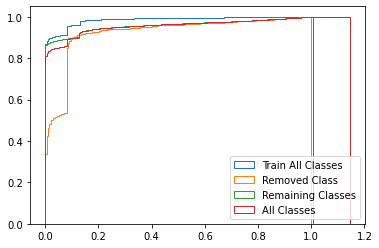

In [15]:
plt.hist(train_dists, bins=200, cumulative=True, density=True, histtype='step', label='Train All Classes');
plt.hist(dists[y_test==8], bins=200, cumulative=True, density=True, histtype='step', label='Removed Class');
plt.hist(dists[y_test!=8], bins=200, cumulative=True, density=True, histtype='step', label='Remaining Classes');
plt.hist(dists, bins=200, cumulative=True, density=True, histtype='step', label='All Classes');
plt.legend(loc='lower right')

In [13]:
np.save(f'{rem}/{rem}_dists.npy', dists)
np.save(f'{rem}/{rem}_train_dists.npy', train_dists)
np.save(f'{rem}/{rem}_pred_vector.npy', np.array(pred_vector))
np.save(f'{rem}/{rem}_train_pred_vector.npy', np.array(train_pred_vector))

FileNotFoundError: [Errno 2] No such file or directory: '3/3_dists.npy'

In [16]:
from os import mkdir

In [20]:
dataset = 'test'
mkdir(f'{dataset}')
mkdir(f'{dataset}/{rem}')